# Выбор локации для скважины

**Задача:** Найти оптимальный регион для бурения скважины.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов.

*Данные представлены признаками*:
- id — уникальный идентификатор скважины
- f0, f1, f2 — три признака точек
- product — объём запасов в скважине (тыс. баррелей)

*Услуовия:*
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые)
- При разведке исследовать 500 точек, из которых выбирают 200 лучших для разработки
- Доход с каждой еденицы продукта составляет 450 тыс. рублей, поскольку обхем указан в тысячах баррелей
- После оценки рисков нужно оставить те регионы, в которых вероятность убытков меньше 2.5%

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

**План работ**:

*Первый этап - Исследование данных*
- Загрузка и ознакомление с данными
- Предобработка данных (если потребуется)
- Проверка признаков на мультиколлениарность

*Второй этап - Обучение модели*
- Разбиение данных на выборки
- Обучение моделей

*Третий этап - Составление итогов*
- Подсчёт прибыли и рисков
- Визуализация решений

## Загрузка и подготовка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor



In [3]:
geo_1 = pd.read_csv('geo_data_0.csv')
geo_2 = pd.read_csv('geo_data_1.csv')
geo_3 = pd.read_csv('geo_data_2.csv')

### Проверка данных первого региона

Определяю функцию для анализа датафреймов.

In [4]:
def data_info(data):
    print('Информация о типах данных')
    print('')
    data.info()
    print('=' * 75)
    
    print('Размер дата фрейма')
    display(data.shape)
    print('=' * 75)
    
    print('Основная статестическая информация')
    display(data.describe().style.format('{0:.2f}'))
    print('=' * 75)
    
    print('Пропущенные значения')
    display(data.isna().sum())
    print('=' * 75)
    
    print('Гистограммы и диаграммы рассеяния фичей')
    sns.pairplot(data, diag_kind='hist', plot_kws={'s': 10});
    plt.show()
    print('=' * 75)
    
    print('Тепловая карта корреляций признаков')
    plt.figure(figsize=(8, 6))
    sns.heatmap(data.corr(), annot=True, fmt='.2f');
    plt.show()
    print('=' * 75)
    
    print('Таблица значений корреляций')
    data.corr()
    print('=' * 75)
    
    print('Подсчёт пропущенных значений')
    print(f'Количество пропущенных значений: {data.isna().sum()}')
    print('=' * 75)
    
    print(f'Количество явных дубликатов: {data.duplicated().sum()}')
    print('=' * 75)
    
    print(f"Количество дубликатов в чистовых столбцах: {data.duplicated(subset=['f0', 'f1', 'f2']).sum()}")
    print('=' * 75)
    
    print('Графики выбросов')
    features = ['f0', 'f1', 'f2']
    fig, axes = plt.subplots(nrows=len(features), figsize=(10, 12))

    for i, feature in enumerate(features):
        sns.boxplot(x=data[feature], ax=axes[i])
        axes[i].set_title(f'Ящик с усами {feature}')
        axes[i].set_xlabel(f'Значения {feature}')

    plt.tight_layout()
    plt.show()
    

Вызовем функцию на каждый дф

Информация о типах данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Размер дата фрейма


(100000, 5)

Основная статестическая информация


,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.25,44.29
min,-1.41,-0.85,-12.09,0.00
25%,-0.07,-0.20,0.29,56.50
50%,0.50,0.25,2.52,91.85
75%,1.07,0.70,4.72,128.56
max,2.36,1.34,16.00,185.36


Пропущенные значения


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Гистограммы и диаграммы рассеяния фичей


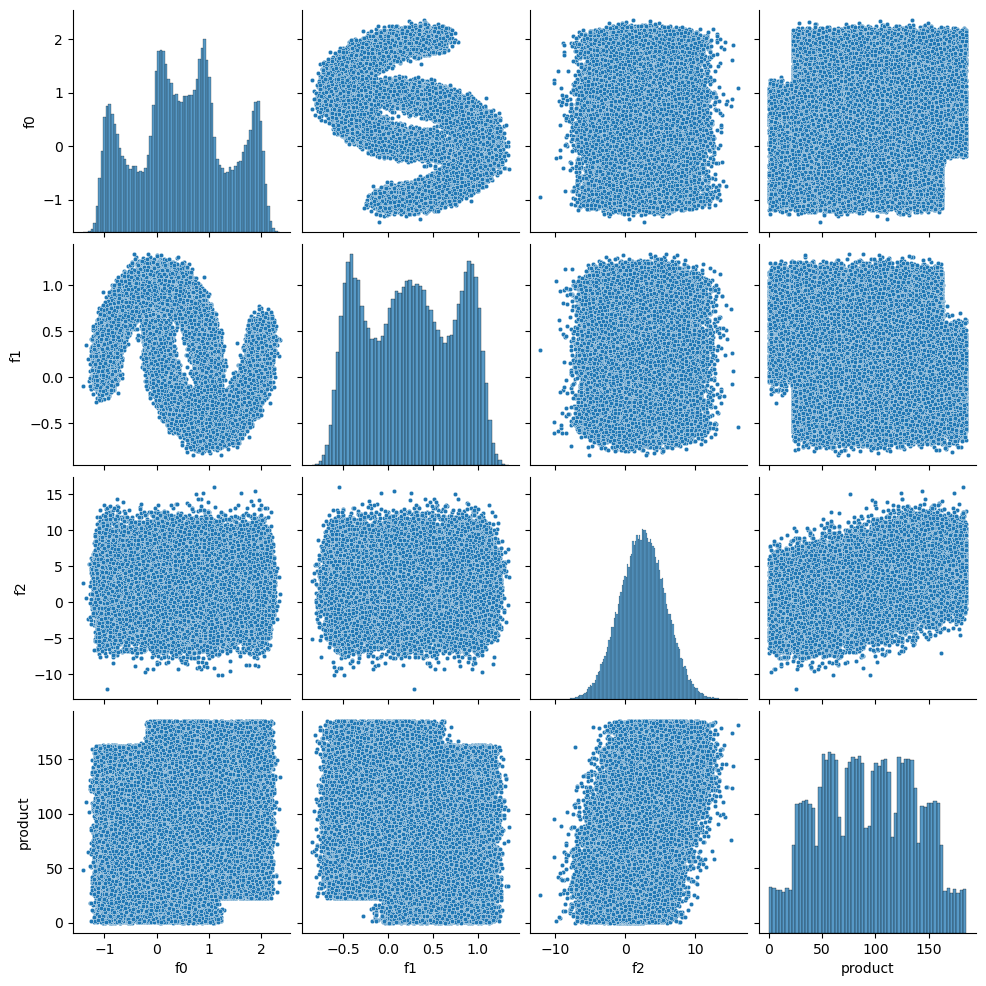

Тепловая карта корреляций признаков


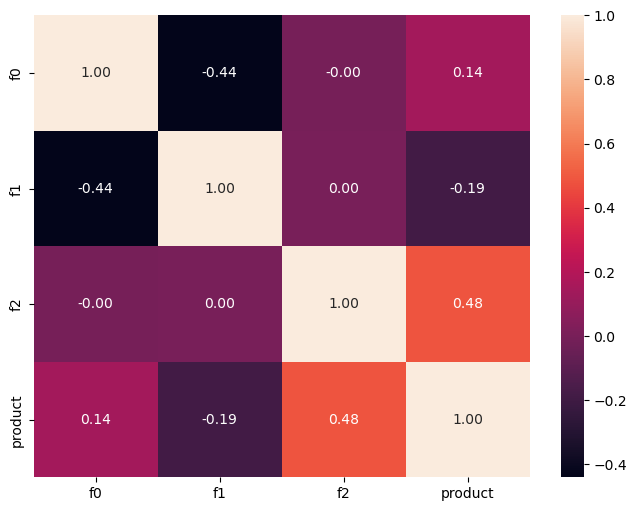

Таблица значений корреляций
Подсчёт пропущенных значений
Количество пропущенных значений: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Количество явных дубликатов: 0
Количество дубликатов в чистовых столбцах: 0
Графики выбросов


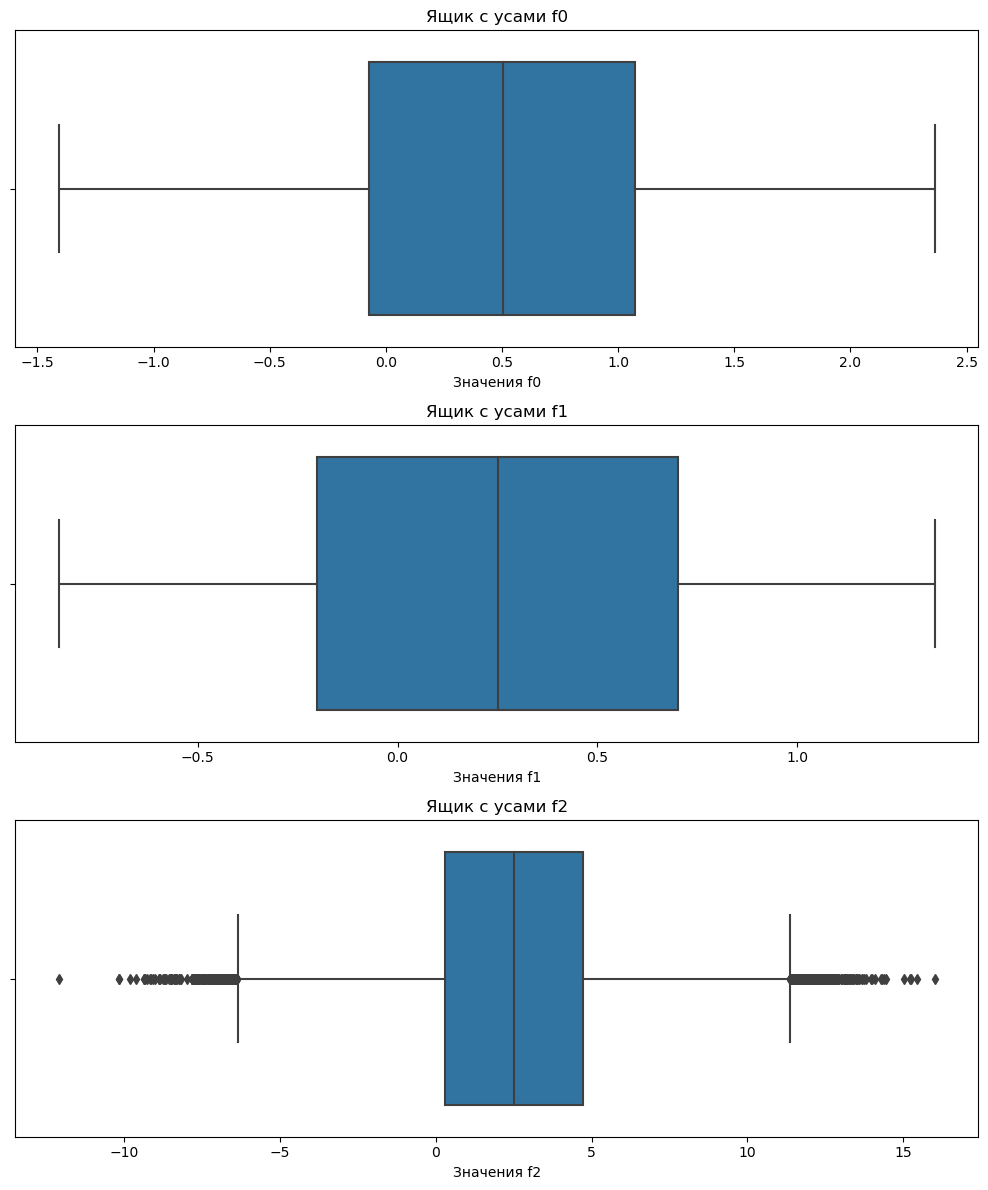

In [5]:
data_info(geo_1)

Пропущенных значений нет, явных дубликатов не наблюдается. Аномалий в данных не обнаружено.

Мультиколлениарности нет. Имеется нелинейная взаимосвязсь признаков `f0` и `f1`.

Есть выбросы в столбце `f2`, с ними планирую бороться с помощью `RobustScaler`.

In [6]:
# удаляю ненужный признак

geo_1.index = geo_1.id
geo_1 = geo_1.drop('id', axis=1)

### Проверка данных второго региона

Информация о типах данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Размер дата фрейма


(100000, 5)

Основная статестическая информация


,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,1.14,-4.80,2.49,68.83
std,8.97,5.12,1.70,45.94
min,-31.61,-26.36,-0.02,0.00
25%,-6.30,-8.27,1.00,26.95
50%,1.15,-4.81,2.01,57.09
75%,8.62,-1.33,4.00,107.81
max,29.42,18.73,5.02,137.95


Пропущенные значения


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Гистограммы и диаграммы рассеяния фичей


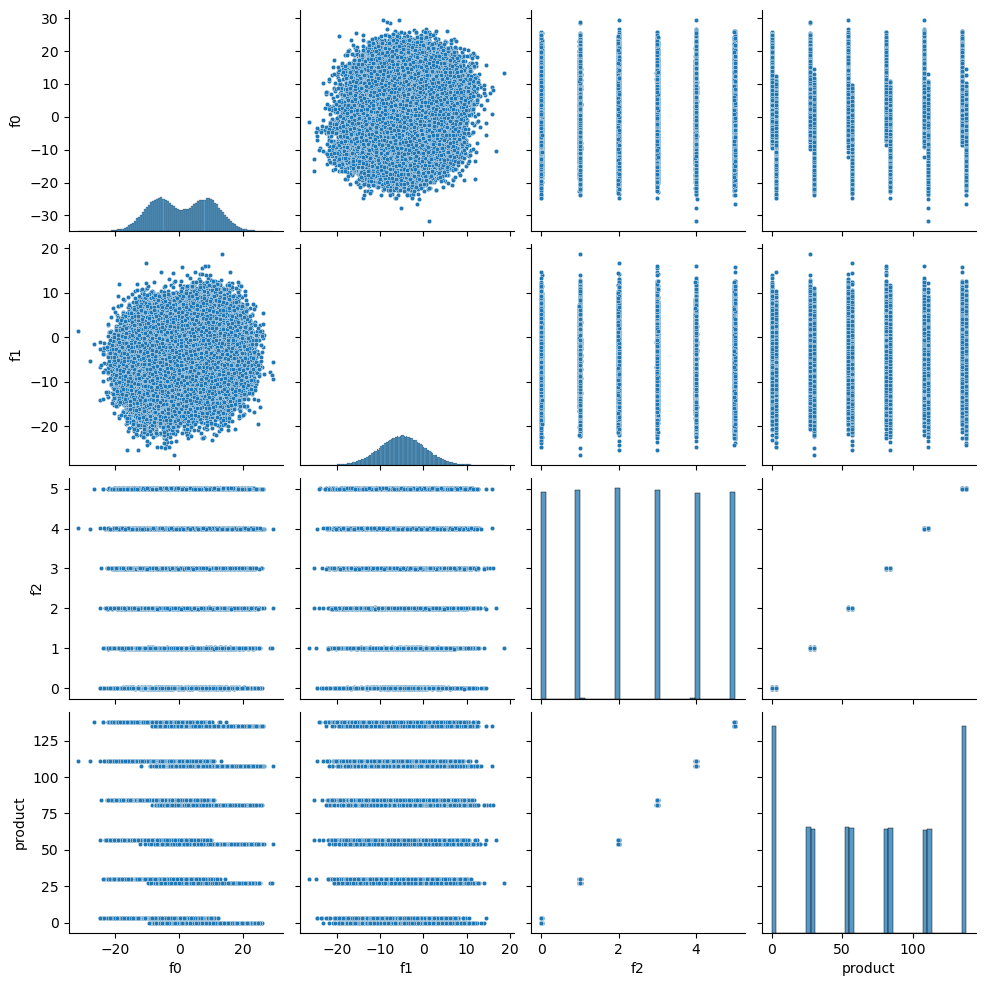

Тепловая карта корреляций признаков


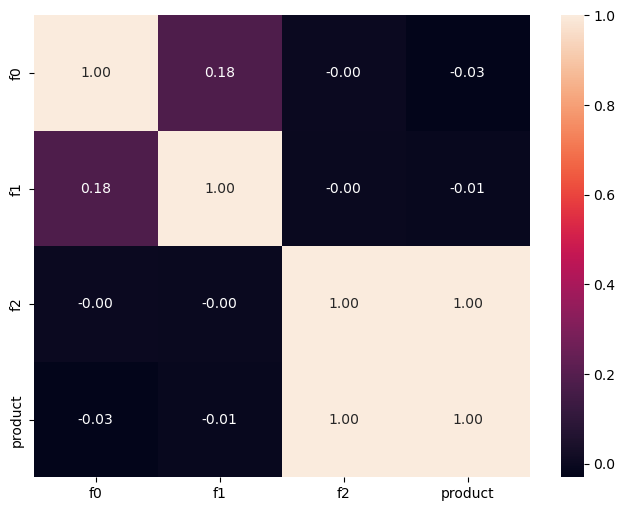

Таблица значений корреляций
Подсчёт пропущенных значений
Количество пропущенных значений: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Количество явных дубликатов: 0
Количество дубликатов в чистовых столбцах: 0
Графики выбросов


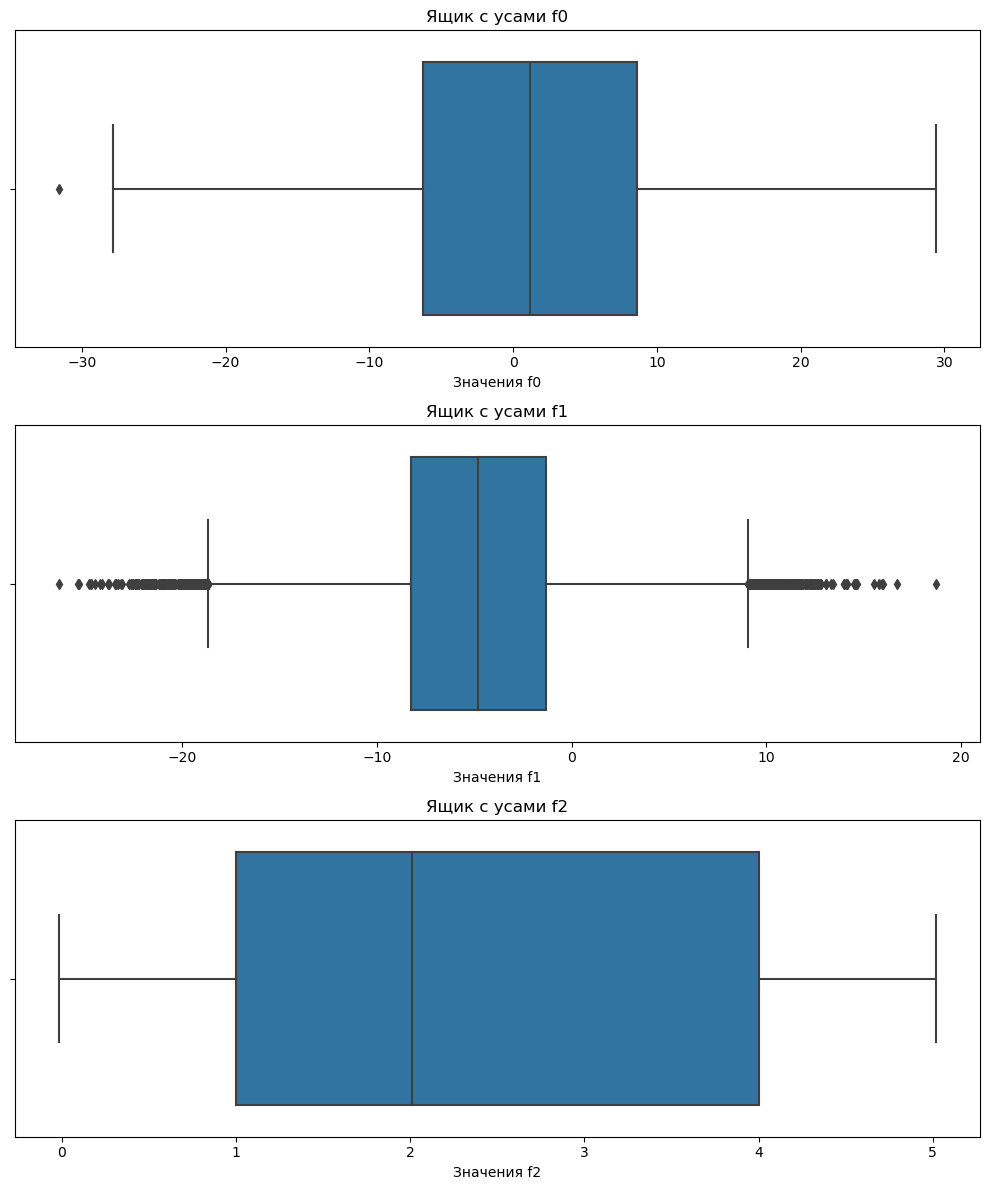

In [7]:
data_info(geo_2)

In [8]:
geo_2['product'].nunique()

12

Имеются очень странные значения в целевом признаке `product`, всего 12 уникальных значений. Имеется почти идеальная корреляция с признаком `f2`.

Скорее всего целевой признак был синтезирован из признака `f2` и эти данные не годятся для работы. Но в отсутствии возможности проверить эту гипотезу, все равно буду анализировать эти данные.

Мультиколлениарности не обнаружено, как и дубликатов. Имеются выбросы в столбце `f1` с которыми я буду бороться с помощью `RobustScaler`.

In [9]:
geo_2.index = geo_2.id
geo_2 = geo_2.drop('id', axis=1)

### Проверка данных третьего региона

Информация о типах данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Размер дата фрейма


(100000, 5)

Основная статестическая информация


,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,0.00,-0.00,2.50,95.00
std,1.73,1.73,3.47,44.75
min,-8.76,-7.08,-11.97,0.00
25%,-1.16,-1.17,0.13,59.45
50%,0.01,-0.01,2.48,94.93
75%,1.16,1.16,4.86,130.60
max,7.24,7.84,16.74,190.03


Пропущенные значения


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Гистограммы и диаграммы рассеяния фичей


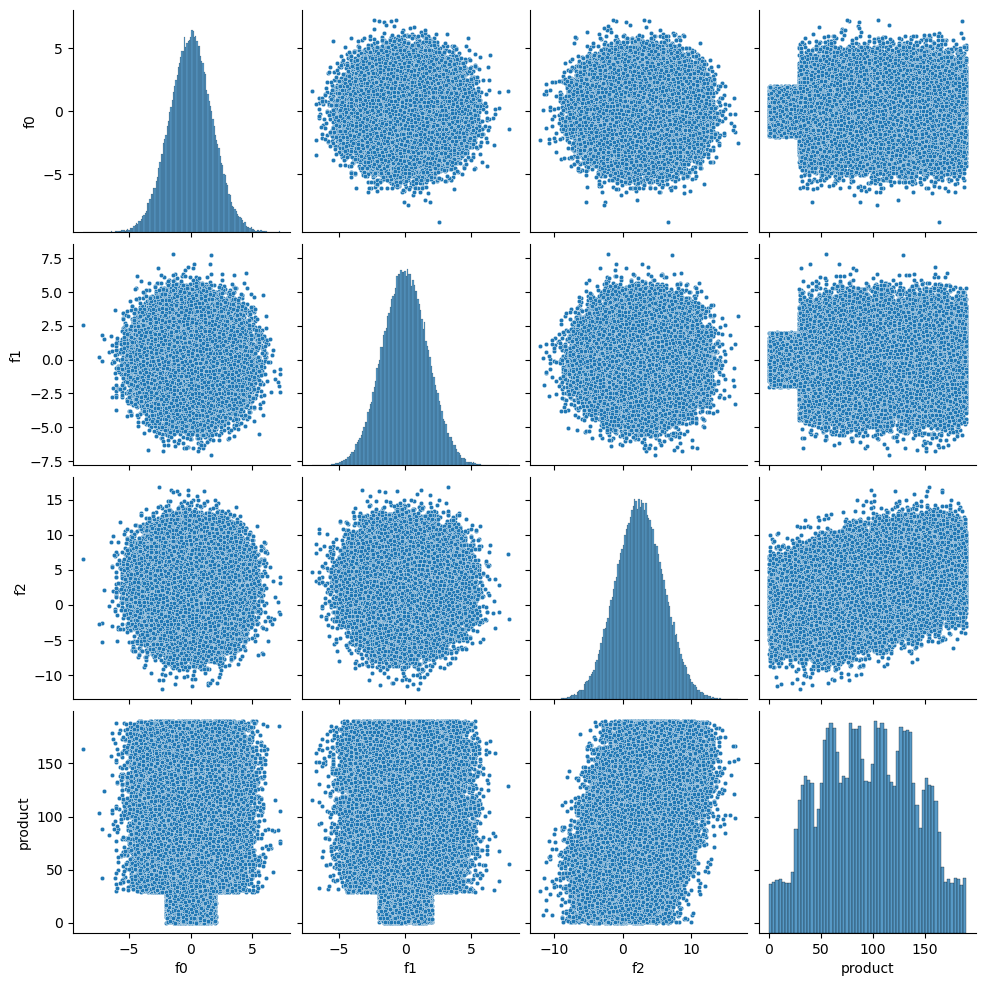

Тепловая карта корреляций признаков


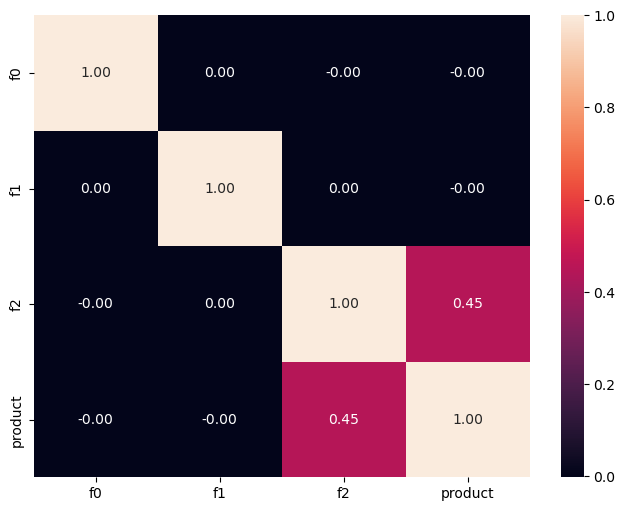

Таблица значений корреляций
Подсчёт пропущенных значений
Количество пропущенных значений: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Количество явных дубликатов: 0
Количество дубликатов в чистовых столбцах: 0
Графики выбросов


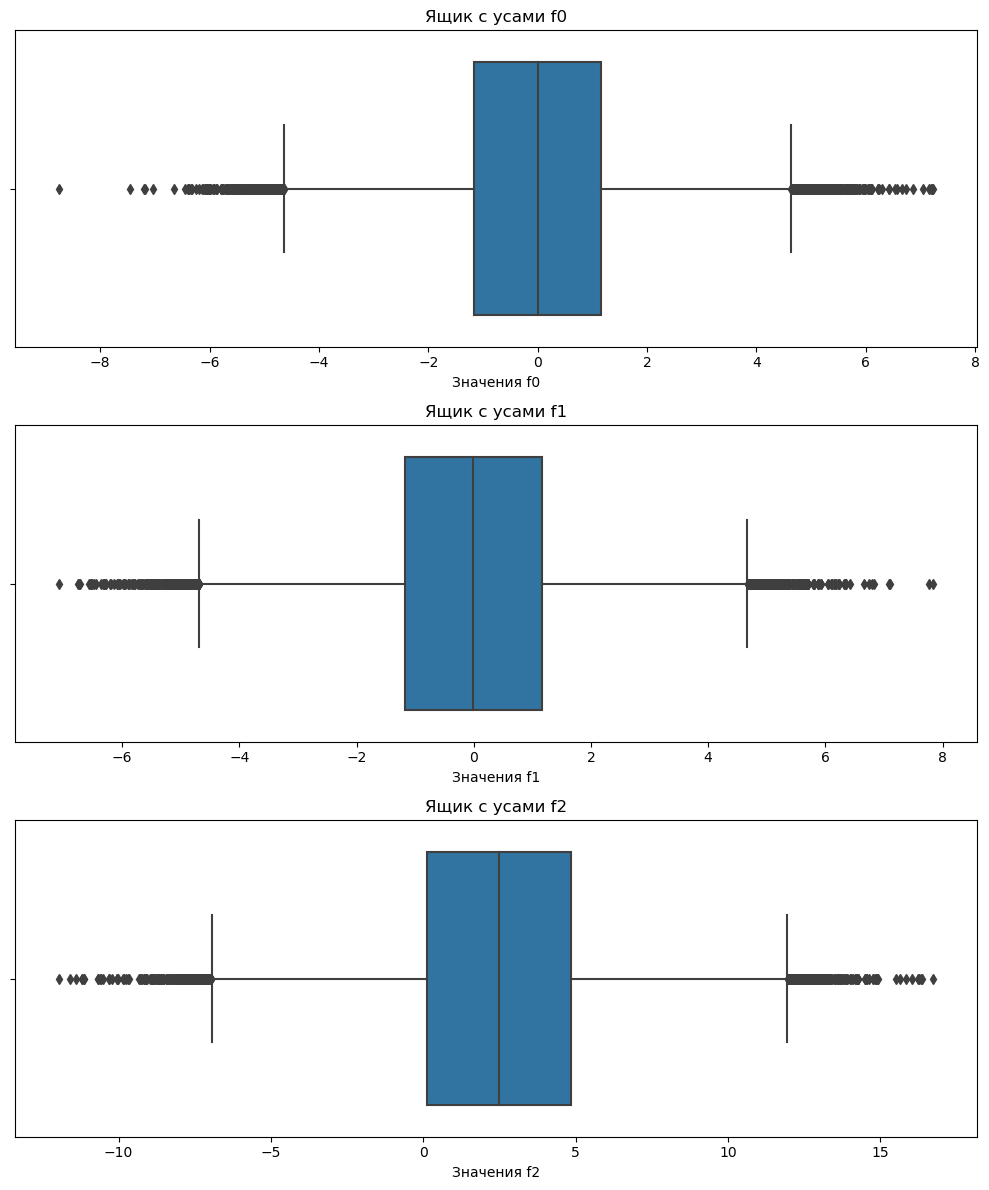

In [10]:
data_info(geo_3)

Аномалий, мультиколлениарности, пропусков в данных не обнаружено.

Имеются выбросы во всех столбцах датасета.

In [11]:
geo_3.index = geo_3.id
geo_3 = geo_3.drop('id', axis=1)

**Промежуточный вывод**

Во всех таблицах отсутствуют пропуски и мультиколлиниарность в признаках.

В таблице `geo_1` имеется очень странное распределение целевого признака `product`. Значения представлены 12-ю уникальными числами, а корреляция с признаком `f2` составляет 100%. Скорее всего связанного с ручным заполнением `product` из признака `f2`. Из-за чего я сомневаюсь в адекватности работы с этой таблицей.

В данных наблюдаются выбросы, с которыми я собираюсь бороться с помощью `RobustScaler`.

## Обучение и проверка модели

Создадим обучающую и валидационную выборки и проверим их точность на голой линейной регрессии.

In [12]:
R_SEED = 32

Определяю функцию по перебору параметров с помощью `GridSearchCV`, где есть перебор `RobustScaler`, `PolynominalFeatures` и `PCA`.

    param_grid = {'model': [LinearRegression(), Ridge(), Lasso()],
                  'model__fit_intercept': [True, False],
                  'poly__degree': [4],
                  'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                  'scaler': [RobustScaler()],
                  'poly__interaction_only': [True, False],
                  'pca__n_components': [0.5, 0.6, 0.85, 0.90, 0.95, None],
                  'pca__whiten': [True, False]}

In [35]:
def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))
    
rmse_scorer = make_scorer(rmse, greater_is_better=False)

def optimize_linear_regression(features_train, target_train):
    
    '''Определяю функцию по перебору параметров с помощью `GridSearchCV`, где есть перебор `RobustScaler`, 
    `PolynominalFeatures` и `PCA`.
    
    Функция принимает обучающие признаки и возвращает лучшую модель, 
    лучшую оценку и стандартное отклонение на переборе данных.'''


    pipeline = Pipeline([('scaler', RobustScaler()),
                         ('poly', PolynomialFeatures()),
                         ('pca', PCA()),
                         ('model', LinearRegression())])
    
    param_grid = [{'model': [LinearRegression()],
                   'model__fit_intercept': [True, False],
                   'poly__degree': [4],
                   'scaler': [RobustScaler()],
                   'poly__interaction_only': [True, False],
                   'pca__n_components': [0.5, 0.6, 0.85, 0.90, 0.95, None],
                   'pca__whiten': [True, False]},
                  {'model': [Ridge()],
                   'model__fit_intercept': [True, False],
                   'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                   'poly__degree': [4],
                   'scaler': [RobustScaler()],
                   'poly__interaction_only': [True, False],
                   'pca__n_components': [0.5, 0.6, 0.85, 0.90, 0.95, None],
                   'pca__whiten': [True, False]},
                  {'model': [Lasso()],
                   'model__fit_intercept': [True, False],
                   'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                   'poly__degree': [4],
                   'scaler': [RobustScaler()],
                   'poly__interaction_only': [True, False],
                   'pca__n_components': [0.5, 0.6, 0.85, 0.90, 0.95, None],
                   'pca__whiten': [True, False]}]



    grid_search = GridSearchCV(pipeline, param_grid=param_grid, 
                                     cv=4, scoring=rmse_scorer, n_jobs=-1, 
                                     verbose=1)

    grid_search.fit(features_train, target_train) 

    print("Лучшее RMSE:", -grid_search.best_score_)

    best_index = grid_search.best_index_
    std_dev = grid_search.cv_results_['std_test_score'][best_index]
    print("Стандартное отклонение для лучшей модели:", std_dev)

    return grid_search.best_estimator_, -grid_search.best_score_, std_dev

### Модель первого региона

In [36]:
features_geo1 = geo_1.drop('product', axis=1)
target_geo1 = geo_1['product']

features_geo1_train, features_geo1_test, target_geo1_train, target_geo1_test = train_test_split(features_geo1,
                                                                                                  target_geo1,
                                                                                                  test_size=0.25,
                                                                                                  random_state=R_SEED)

In [37]:
best_model_geo1, best_score_geo1, std_geo1 = optimize_linear_regression(features_geo1_train, target_geo1_train)

# Таблица с результатами
results = pd.DataFrame({'Model': ['geo_1'], 
                        'Лучшая RMSE оценка': [best_score_geo1], 
                        'Стандартное отклонение': [std_geo1]})

results

Fitting 4 folds for each of 624 candidates, totalling 2496 fits
Лучшее RMSE: 37.30682651086684
Стандартное отклонение для лучшей модели: 0.06830965893242502


,Model,Лучшая RMSE оценка,Стандартное отклонение
0,geo_1,37.306827,0.06831


Посмотрим, как изменится точность модели, если мы добавим скалирование признаков.

### Модель второго региона

In [38]:
features_geo2 = geo_2.drop('product', axis=1)
target_geo2 = geo_2['product']

features_geo2_train, features_geo2_test, target_geo2_train, target_geo2_test = train_test_split(features_geo2,
                                                                                                  target_geo2,
                                                                                                  test_size=0.25,
                                                                                                  random_state=R_SEED)

In [39]:
best_model_geo2, best_score_geo2, std_geo2 = optimize_linear_regression(features_geo2_train, target_geo2_train)

new_row = pd.DataFrame({'Model': ['geo_2'],
                        'Лучшая RMSE оценка': [best_score_geo2],
                        'Стандартное отклонение': [std_geo2]})

results = results.append(new_row, ignore_index=True)

Fitting 4 folds for each of 624 candidates, totalling 2496 fits
Лучшее RMSE: 0.7796693339314714
Стандартное отклонение для лучшей модели: 0.002451872693704251


### Модель третьего региона

In [40]:
features_geo3 = geo_3.drop('product', axis=1)
target_geo3 = geo_3['product']

features_geo3_train, features_geo3_test, target_geo3_train, target_geo3_test = train_test_split(features_geo3,
                                                                                                  target_geo3,
                                                                                                  test_size=0.25,
                                                                                                  random_state=R_SEED)

In [41]:
best_model_geo3, best_score_geo3, std_geo3 = optimize_linear_regression(features_geo3_train, target_geo3_train)

new_row = pd.DataFrame({'Model': ['geo_3'],
                        'Лучшая RMSE оценка': [best_score_geo3],
                        'Стандартное отклонение': [std_geo3]})

results = results.append(new_row, ignore_index=True)

Fitting 4 folds for each of 624 candidates, totalling 2496 fits
Лучшее RMSE: 38.25285535154857
Стандартное отклонение для лучшей модели: 0.30458060244335666


**Промежуточные выводы:**

Лучшие результаты показала `Локация №2` c её `RMSE` значенимем в `0.78`. Такая маленькая ошибка частичто подтверждает подозрения о ошибочности данные во 2-й таблице.

Следующая по качеству `Локация №1` её `RMSE = 37.3`. Она не сильно опережает `Локацию №3`, всего лишь на `1`, но значительно лучше по стандартному отклонению. Что может говорить, о плохом подборе гипперпараметров для `Локации №3` или же данные сами по себе более хаотичны и сложнопрогнозируемы.

|    | Model   |   Лучшая RMSE оценка |   Стандартное отклонение |
|---:|:--------|---------------------:|-------------------------:|
|  0 | geo_1   |            37.3083   |               0.161611   |
|  1 | geo_2   |             0.779125 |               0.00376952 |
|  2 | geo_3   |            38.2563   |               0.200548   |

## Проверка моделей на адекватность

Определяю функцию по проверки моделей на адекватность.

In [42]:
def sanity_checker(model, features_test, target_test):
    
    '''Функция проверяет адекватность модели, сравнивая результаты предсказания заданной модели с моделью
    предсказывающую только среднее значение.
    
    На вход подаётся лучшая модель, признаки для теста и целевой признак для теста
    
    Модель выводит результат - Прошла модель проверку или нет. И выводит значения оценок RMSE'''
    
    predictions = model.predict(features_test)
    rmse_m = mean_squared_error(target_test, predictions)**0.5
    
    
    dummy = DummyRegressor(strategy="mean")
    dummy.fit(features_test, target_test)
    dummy_pred = dummy.predict(features_test)
    dummy_rmse = rmse(target_test, dummy_pred)
    
    if rmse_m > dummy_rmse:
        print(f"Модель НЕ прошла проверку на адекватность dummy_rmse {dummy_rmse}\
 больше оценки модели {rmse_m}")
    else: print(f"Модель прошла проверку на адекватность dummy_rmse {dummy_rmse}\
 больше оценки модели {rmse_m}")

In [43]:
sanity_checker(best_model_geo1, features_geo1_test, target_geo1_test)

Модель прошла проверку на адекватность dummy_rmse 44.285390452766656 больше оценки модели 37.212732238706565


In [44]:
sanity_checker(best_model_geo2, features_geo2_test, target_geo2_test)

Модель прошла проверку на адекватность dummy_rmse 46.050693997807535 больше оценки модели 0.7915195008778171


In [45]:
sanity_checker(best_model_geo3, features_geo3_test, target_geo3_test)

Модель прошла проверку на адекватность dummy_rmse 44.6855311943803 больше оценки модели 38.0454764719358


**Промежуточный вывод:**

Все модели показали себя значительно лучше моделей предсказывающих средние значения.

## Подготовка к расчёту прибыли

Создадим константы, пригодящиеся для дальшейних расчётов.

In [46]:
BUDGED = 10_000_000_000 # Общий бюджет
SCOUT_POINTS = 500 # Количество скважин для разведки
POINTS = 200 # Количество скважин для разработки
INCOME = 450_000 # Доход за единицу продукта
BUDGET_PER_POINT = BUDGED / POINTS # Бюджет на 1 скважину
MIN_PRODUCT = BUDGET_PER_POINT / INCOME # минимальное количество продукта со скважины для безубыточной разработки

In [47]:
print(f'Минимальные запасы сырья для безубыточной разработки скважины {round(MIN_PRODUCT, 2)}')
print('-' * 75)
print()
print(f'Средние запасы сырья для скважены для Первого региона {geo_1["product"].mean()}')
print('-' * 75)
print()
print(f'Средние запасы сырья для скважены для Второго региона {geo_2["product"].mean()}')
print('-' * 75)
print()
print(f'Средние запасы сырья для скважены для Третьего региона {geo_3["product"].mean()}')
print('-' * 75)

Минимальные запасы сырья для безубыточной разработки скважины 111.11
---------------------------------------------------------------------------

Средние запасы сырья для скважены для Первого региона 92.49999999999974
---------------------------------------------------------------------------

Средние запасы сырья для скважены для Второго региона 68.82500000002561
---------------------------------------------------------------------------

Средние запасы сырья для скважены для Третьего региона 95.00000000000041
---------------------------------------------------------------------------


**Каждый регион убыточен по средним значениям скважин.**

Самым бедным регионом является второй, среднее количество сырья в скважине 68.82. Но он имеет самую точную модель.

Первый же и третий регионы примерно одинаковы. И их средние значения равны 92.50 и 95.

## Расчёт прибыли и рисков 

Создаю функцию расчёта прибыли.

In [48]:
def revenue(predictions, true_values):
    # Cоздаю из массива predictions Series и присваиваю ему индексы из истинных значений
    predictions = pd.Series(predictions, index=true_values.index)
    
    # Нахожу ТОП200 самых больших по продукту месторождений по нашим предсказаниям
    indexes = predictions.sort_values(ascending=False).index
    # Расчитываю выручку
    rev = (true_values[indexes][:200].sum() * INCOME) - BUDGED # => Изменил названия констант
    return round(rev, 2)

In [49]:
def revenue(predictions, true_values):
    if len(predictions) < 200:
        raise ValueError("Недостаточная выборка")
    
    # Cоздаю из массива predictions Series и присваиваю ему индексы из истинных значений
    predictions = pd.Series(predictions, index=true_values.index)
    
    # Нахожу ТОП200 самых больших по продукту месторождений по нашим предсказаниям
    indexes = predictions.sort_values(ascending=False).index
    # Расчитываю выручку
    rev = (true_values[indexes][:200].sum() * INCOME) - BUDGED # => Изменил названия констант
    return round(rev, 2)

Создадим функцию, которая должна по предсказанным значениям дать список подвыборок прибыли, границы доверительного инревала и вероятность убыточности.

In [50]:
def revenue_and_risk(predictions, true_values):
    random_state = np.random.RandomState(R_SEED)
    # Создаю список, куда буду сохранять значения выручки из подвыборок
    revenues = []
    # Переиндексирую списки, чтобы код работал верно
    predictions = pd.Series(predictions)
    predictions.index = true_values.index
    for i in range(1000):
        true_subsample = true_values.sample(SCOUT_POINTS, replace=True, random_state=random_state)
        predictions_subsample = predictions[true_subsample.index]
        
        # Создание временного индекса
        true_subsample = true_subsample.reset_index(drop=True)
        predictions_subsample = pd.Series(predictions_subsample.values)
        
        revenues.append(revenue(predictions_subsample, true_subsample))
        
    revenues = pd.Series(revenues)
    lower = revenues.quantile(0.025) 
    upper = revenues.quantile(0.975)
    risk = (revenues < 0).mean()
    
    return revenues, lower, upper, risk

Средняя прибыль 397658876.61
Вероятность отрицательный прибыли: 0.098


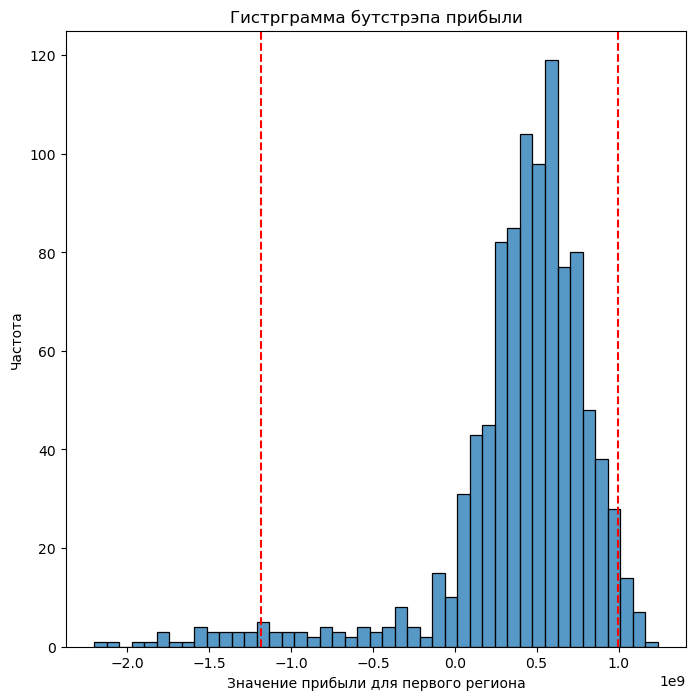

In [51]:
geo_1_predictions = best_model_geo1.predict(features_geo1_test)

rev_list, lower, upper, risk = revenue_and_risk(geo_1_predictions, target_geo1_test)
 
print(f'Средняя прибыль {round(rev_list.mean(), 2)}')
print('Вероятность отрицательный прибыли:', risk)
plt.figure(figsize=(8 , 8))
sns.histplot(rev_list)
plt.axvline(lower, color='red', linestyle='--')
plt.axvline(upper, color='red', linestyle='--') 
plt.ylabel('Частота')
plt.xlabel('Значение прибыли для первого региона')
plt.title('Гистрграмма бутстрэпа прибыли')
plt.show();

Средняя прибыль 500989647.82
Вероятность отрицательный прибыли: 0.014


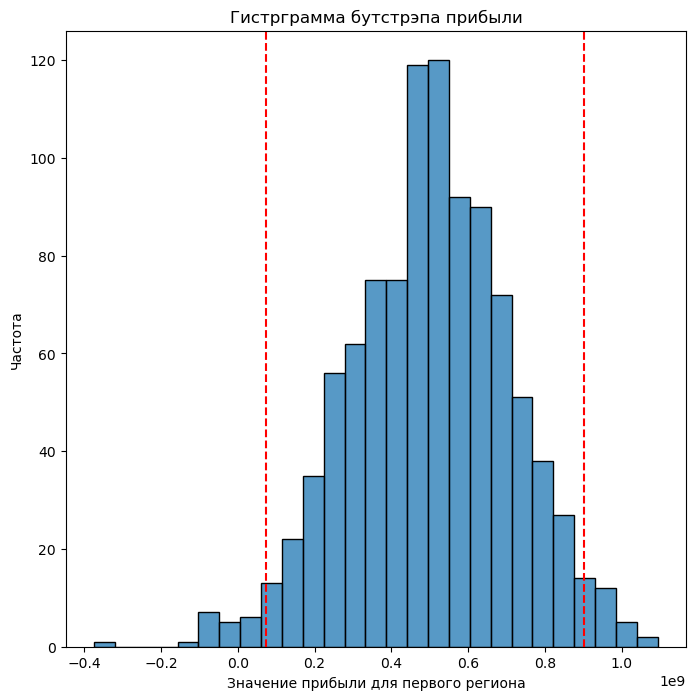

In [52]:
geo_2_predictions = best_model_geo2.predict(features_geo2_test)

rev_list, lower, upper, risk = revenue_and_risk(geo_2_predictions, target_geo2_test)
 
print(f'Средняя прибыль {round(rev_list.mean(), 2)}')
print('Вероятность отрицательный прибыли:', risk)
plt.figure(figsize=(8 , 8))
sns.histplot(rev_list)
plt.axvline(lower, color='red', linestyle='--')
plt.axvline(upper, color='red', linestyle='--') 
plt.ylabel('Частота')
plt.xlabel('Значение прибыли для первого региона')
plt.title('Гистрграмма бутстрэпа прибыли')
plt.show();

Средняя прибыль 610234413.22
Вероятность отрицательный прибыли: 0.037


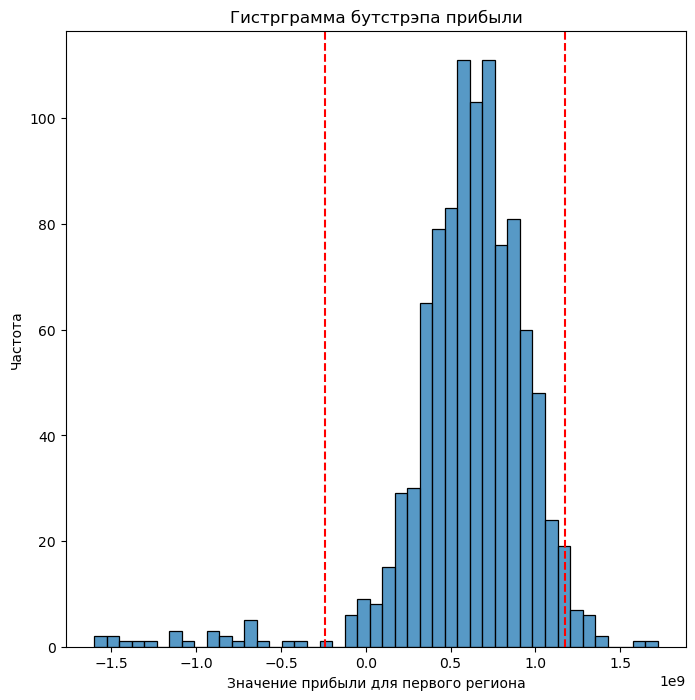

In [53]:
geo_3_predictions = best_model_geo3.predict(features_geo3_test)

rev_list, lower, upper, risk = revenue_and_risk(geo_3_predictions, target_geo3_test)
 
print(f'Средняя прибыль {round(rev_list.mean(), 2)}')
print('Вероятность отрицательный прибыли:', risk)
plt.figure(figsize=(8 , 8))
sns.histplot(rev_list)
plt.axvline(lower, color='red', linestyle='--')
plt.axvline(upper, color='red', linestyle='--') 
plt.ylabel('Частота')
plt.xlabel('Значение прибыли для первого региона')
plt.title('Гистрграмма бутстрэпа прибыли')
plt.show();

## Вывод

<div style='border:solid blue 2px; padding: 10px'>
    
*Только 1 регион удовлетворяют условию "Вероятность убытков менее 2.5%"*

- Самым прибыльным является Третий регион с его показателем прибыли **610 234 413.22** и вероятностью убытков в **3.7%**
- Самым безопасным регионом является Второй с его показателм прибыли **500 989 647.82** и рисками в **1.4%**
- Первый регион проигрывает по всем показателям с его выручкой **397 658 876.61** и рисками **9.8%**

    
**Данные со второго региона выглядят недоставерно, будто их создавали вручную.**
- Исходя из этого, стоит перепроверить источник данных
- Если перепроверить источник нельзя или данные были ложными, лучшим регионом по вкладам будет *Третий регион*, доступным минимумом рисков.